In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import requests
import warnings

# catch all future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
#finnhub_api_key = 'd399a2hr01ql85dgp6vgd399a2hr01ql85dgp700'

# Overview

In [248]:
sectors_list = [
    'basic-materials'
    ,'communication-services'
    ,'consumer-cyclical'
    ,'consumer-defensive'
    ,'energy'
    ,'financial-services'
    ,'healthcare'
    ,'industrials'
    ,'real-estate'
    ,'technology'
    ,'utilities'
]

In [4]:
sectors_overview = []
for sector in sectors_list:
    overview = yf.Sector(sector).overview
    overview['sector'] = yf.Sector(sector).name
    sectors_overview.append(overview)

In [5]:
sectors_df = pd.DataFrame(sectors_overview)

In [ ]:
industries_list = []
for sector in sectors_list:
    industries = list(yf.Sector(sector).industries.reset_index()['key'])
    industries_list.extend(industries)

In [8]:
industries_overview = []
for industry in industries_list:
    overview = yf.Industry(industry).overview
    overview['industry'] = yf.Industry(industry).name
    industries_overview.append(overview)

In [9]:
industries_df = pd.DataFrame(industries_overview)

In [ ]:
sector_industry = []
for sector_key in sectors_list:
    sec = yf.Sector(sector_key)
    inds = sec.industries  # DataFrame with columns like: key, name, symbol, weight

    # If a sector has no industries for some reason, skip cleanly
    if inds is None or inds.empty:
        continue

    # Use the industry "name" as the label; you could also use "key" if you prefer --> key preferred
    for industry_key in inds.index:
        sector_industry.append({
            "sector": sector_key,
            "industry": industry_key
        })

sector_industry_df = pd.DataFrame(sector_industry)

              sector                               industry
0    basic-materials                    specialty-chemicals
1    basic-materials                                   gold
2    basic-materials                     building-materials
3    basic-materials                                 copper
4    basic-materials                                  steel
..               ...                                    ...
140        utilities  utilities-independent-power-producers
141        utilities                utilities-regulated-gas
142        utilities                  utilities-diversified
143        utilities                    utilities-renewable
144        utilities              utilities-regulated-water

[145 rows x 2 columns]


In [10]:
markets_list = [
    'US'
    ,'GB'
    ,'ASIA'
    ,'EUROPE'
    ,'RATES'
    ,'COMMODITIES'
    ,'CURRENCIES'
    ,'CRYPTOCURRENCIES'
]

In [11]:
markets_overview = []
for market in markets_list:
    summary = list(yf.Market(market).summary.values())
    markets_overview.extend(summary)

In [12]:
markets_df = pd.DataFrame(markets_overview)[['typeDisp','shortName','exchange','market','fullExchangeName','exchangeTimezoneName','symbol']]

In [13]:
top_companies = pd.DataFrame()
for industry in industries_list:
    companies = yf.Industry(industry).top_companies
    if companies is not None:
        companies['industry'] = industry
        top_companies = pd.concat([top_companies, companies], ignore_index=False)
    else:
        print(f"No data for industry: {industry}")

No data for industry: pharmaceutical-retailers
No data for industry: infrastructure-operations


In [14]:
tickers = list(top_companies.index)

In [15]:
# get company information

def company_info(ticker, freq='yearly'):
    
    from IPython.display import display

    full_info = yf.Ticker(ticker).info
    
    # get company general info
    general_extract = ['city','state','country','industry','sector','fullTimeEmployees','website']
    general = {k: full_info[k] for k in general_extract if k in full_info}
    general_df = pd.DataFrame(general, index=[0])

    # get company officers information
    officers = full_info['companyOfficers']
    officers_df = pd.DataFrame(officers)
    officers_df = officers_df.drop('maxAge', axis=1)

    # get risk metrics
    risk_metrics = ['auditRisk','boardRisk','compensationRisk','shareHolderRightsRisk','overallRisk']
    risk = {k: full_info[k] for k in risk_metrics if k in full_info}
    risk_df = pd.DataFrame(risk, index=['Value']).T

    # get targeted KPIs
    trailing_is = yf.Ticker(ticker).get_income_stmt(freq='trailing', pretty=False, as_dict=False)
    yearly_is = yf.Ticker(ticker).get_income_stmt(freq=freq, pretty=False, as_dict=False)
    trailing_cf = yf.Ticker(ticker).get_cashflow(freq='trailing', pretty=False, as_dict=False)
    yearly_cf = yf.Ticker(ticker).get_cashflow(freq=freq, pretty=False, as_dict=False)
    
    if freq == 'yearly':
        income_st_df = trailing_is.loc[['GrossProfit', 'TotalRevenue']].join(yearly_is.loc[['GrossProfit', 'TotalRevenue']])
        cash_flow_df = trailing_cf.loc[['FreeCashFlow']].join(yearly_cf.loc[['FreeCashFlow']])
    else:
        income_st_df = yearly_is.loc[['GrossProfit', 'TotalRevenue']]
        cash_flow_df = yearly_cf.loc[['FreeCashFlow']]
    
    kpi_df = pd.concat([income_st_df, cash_flow_df])

    # calculate percent change for the KPIs
    kpi_df = kpi_df[sorted(kpi_df.columns)]
    growth = kpi_df.T.pct_change().T * 100
    kpi_df = kpi_df[sorted(kpi_df.columns, reverse=True)]
    growth = growth[sorted(growth.columns, reverse=True)]

    # function to format large numbers
    def format_large(x):
        if pd.isna(x):
            return ""
        elif abs(x) >= 1e9:
            return f"{x/1e9:.1f}B"
        elif abs(x) >= 1e6:
            return f"{x/1e6:.1f}M"
        else:
            return f"{x:.0f}"
    
    kpi_df = kpi_df.map(format_large)

    # format growth percentages
    growth = growth.map(lambda x: f"{x:.1f}%" if pd.notna(x) else "")

    display(general_df)
    display(officers_df)
    display(risk_df)
    display(kpi_df)
    display(growth)

In [16]:
# get targeted metrics

def target_metrics(ticker):
    t = yf.Ticker(ticker)
    
    income_statement = t.get_income_stmt(freq='quarterly', pretty=False, as_dict=False)
    cash_flow = t.get_cashflow(freq='quarterly', pretty=False, as_dict=False)

    # Safe lookup: keep only rows that exist
    income_keys = ['GrossProfit', 'TotalRevenue']
    cashflow_keys = ['FreeCashFlow']

    available_income = [k for k in income_keys if k in income_statement.index]
    available_cashflow = [k for k in cashflow_keys if k in cash_flow.index]

    income_st_df = income_statement.loc[available_income] if available_income else pd.DataFrame()
    cash_flow_df = cash_flow.loc[available_cashflow] if available_cashflow else pd.DataFrame()

    joined_df = pd.concat([income_st_df, cash_flow_df])

    if joined_df.empty:
        return pd.DataFrame()  # return empty if nothing found

    metrics_df = joined_df.T.reset_index(names='quarter')
    metrics_df['ticker'] = ticker

    return metrics_df


In [17]:
# 1. Query last quarter per ticker from SQLite

import sqlite3

def get_last_quarters(db_path):
    conn = sqlite3.connect(db_path)
    query = """
    SELECT ticker, MAX(quarter) as last_quarter
    FROM TGTMETRICS
    GROUP BY ticker
    """
    last_quarters = pd.read_sql(query, conn)
    conn.close()
    return last_quarters


# 2. Update function with SQLite integration

def update_metrics_sqlite(db_path, tickers):
    # Get last quarters already stored
    last_quarters = get_last_quarters(db_path)

    conn = sqlite3.connect(db_path)

    for ticker in tickers:
        # Latest known quarter in DB
        last_q = last_quarters.loc[
            last_quarters['ticker'] == ticker, 'last_quarter'
        ]
        last_q = last_q.iloc[0] if not last_q.empty else None

        # Get full Yahoo data
        metrics = target_metrics(ticker)
        if metrics.empty:
            continue

        # Keep only new quarters
        if last_q:
            new_rows = metrics[metrics['quarter'] > last_q]
        else:
            new_rows = metrics  # nothing stored yet

        if not new_rows.empty:
            new_rows.to_sql("metrics", conn, if_exists="append", index=False)
            print(f"{ticker}: added {len(new_rows)} new rows")
        #else:
        #    print(f"{ticker}: no new data")

    conn.close()



In [ ]:
#########################################################
##########         FIRST TIME ONLY !!!         ##########
#########################################################
'''
ticker_df = pd.DataFrame()
for ticker in tickers:
    metrics = target_metrics(ticker)
    ticker_df = pd.concat([ticker_df, metrics], ignore_index=True)
'''
#########################################################
#########################################################

db_path = "financial_analytics.db"
new_ticker_df = update_metrics_sqlite(db_path, tickers)


LIN: added 1 new rows
SHW: added 1 new rows
ECL: added 1 new rows
APD: added 1 new rows
PPG: added 1 new rows
IFF: added 1 new rows
DD: added 1 new rows
LYB: added 1 new rows
ALB: added 1 new rows
RPM: added 1 new rows
WLK: added 1 new rows
SOLS: added 3 new rows
NEU: added 1 new rows
EMN: added 1 new rows
AXTA: added 1 new rows
ESI: added 1 new rows
BCPC: added 1 new rows
SXT: added 1 new rows
PRM: added 1 new rows
CBT: added 1 new rows
AVNT: added 1 new rows
HWKN: added 1 new rows
WDFC: added 1 new rows
ASH: added 1 new rows
KWR: added 1 new rows
CC: added 1 new rows
NGVT: added 1 new rows
IOSP: added 1 new rows
MTX: added 1 new rows
CLMT: added 1 new rows
ECVT: added 1 new rows
SCL: added 1 new rows
MATV: added 1 new rows
KOP: added 1 new rows
KRO: added 1 new rows
HDSN: added 1 new rows
OEC: added 1 new rows
CMT: added 1 new rows
FSI: added 1 new rows
NTIC: added 1 new rows
NEM: added 1 new rows
AU: added 1 new rows
RGLD: added 1 new rows
CDE: added 1 new rows
SA: added 1 new rows


# Database Setup

In [19]:
from sqlalchemy import create_engine

# Connect to SQLite database (file-based)
engine = create_engine('sqlite:///financial_analytics.db')  # This creates database in the current folder

We will create some master tables from the sector, industry, market and top companies data. These will follow a naming convention of starting with 'M' (e.g. <b>MSECTOR</b>).

Then we will create the operational tables which will be periodically updated. <i>(Maybe every quarter?)</i>

### Master Tables

In [255]:
# Write DataFrame to SQL (replace table if exists)
sectors_df.to_sql('MSECTOR', engine, if_exists='replace', index=False)
industries_df.to_sql('MINDUSTRY', engine, if_exists='replace', index=False)
sector_industry_df.to_sql('MSECTORINDUSTRY', engine, if_exists='replace', index=False)
markets_df.to_sql('MMARKET', engine, if_exists='replace', index=False)
top_companies.to_sql('MCOMPANIES', engine, if_exists='replace', index=True)

2674

In [25]:
new_ticker_df

### Metrics tables

In [ ]:
#########################################################
##########         FIRST TIME ONLY !!!         ##########
#########################################################

# Write DataFrame to SQL (first time)
#ticker_df.to_sql('TGTMETRICS', engine, if_exists='replace', index=False)

#########################################################
#########################################################

# Write DataFrame to SQL (new data)
new_ticker_df.to_sql('TGTMETRICS', engine, if_exists='append', index=False)

17233

# Fundamental Trading Strategies

### Gross Profit Growth Strategy
Gross profit represents a company's revenue after deducting the cost of goods sold, and its growth indicates the company's **efficiency** and **pricing power**. 

- *<u>Identify growing margins</u>*: Investors can look for companies that consistently increase their gross profit margin, which suggests effective management of production costs or the ability to charge higher prices.

- *<u>Industry comparison</u>>*: Comparing a company's gross margin with its industry peers can reveal if it's more efficient at converting sales into profit. A company with higher gross profit growth relative to competitors may have a competitive advantage.  

### Total Revenue Growth Strategy
Consistent total revenue growth indicates **increasing demand for a company's products or services** and **market expansion**. 

- *<u>Track growth trends</u>*: Look for companies with sustainable and steady revenue growth over time. While an annual growth rate of 15% to 25% is often considered healthy, extremely high rates might overwhelm a business.
  
- *<u>Screen for growth stocks</u>*: Use stock screeners to find companies with accelerating revenue growth, which can signal high-potential growth stocks.
  
- *<u>Assess competitive position</u>*: Evaluate revenue growth in the context of industry trends and macroeconomic factors. Companies that can maintain growth despite economic headwinds are often considered resilient.

### Free Cash Flow Growth Strategy
Free cash flow (FCF) is the cash a company generates after covering its operating expenses and capital expenditures. Strong FCF growth is a sign of **financial health** and **flexibility**.

- *<u>High FCF yield</u>*: A high FCF yield, which compares FCF per share to the market value per share, indicates that a company can easily meet its obligations and return cash to shareholders.
  
- *<u>Financial flexibility</u>*: Companies with strong FCF can reinvest in the business, make acquisitions, pay dividends, or buy back shares, all of which can enhance shareholder value.

- *<u>All-weather strategy</u>*: Strategies based on strong FCF can be effective in all market conditions, as they focus on a company's fundamental ability to generate cash. 

## Integrated Strategy
To find **financially robust** companies, investors can combine all three metrics in a screening process:

1. **<u>Start with revenue</u>**: Screen for companies with consistent revenue growth to identify businesses with strong market demand.

2. **<u>Refine with gross profit</u>**: Filter for companies that are also growing their gross profit. This ensures the revenue growth is translating into profitability and isn't solely driven by price reductions.

3. **<u>Confirm with free cash flow</u>**: Select the final companies based on their free cash flow growth. This step confirms that the company is effectively managing its cash and has the financial strength to support future growth and reward investors. 

In [256]:
def integrated_strategy():
    df = pd.read_sql('SELECT * FROM GROWTH_STRATEGIES', engine)

    ## find financial robustness based on 3 metrics
    
    rating = df['rating'].isin(['Strong Buy','Buy'])
    
    # Total Revenue signals
    health = (df['TotalRevenueGrowthAvg'] > 15) & (df['TotalRevenueGrowthAvg'] <= 25)
    rank = df['TotalRevenueIndustryRank'] >= 5
    performance = df['TotalRevenueGrowthPerformance'] == 'Overperforms'
    df['Signal_Revenue'] = (
        np.where(rating, 1, 0) + 
        np.where(health, 1, 0) + 
        np.where(rank, 1, 0) + 
        np.where(performance, 1, 0)
        )
    
    # Gross Profit signals
    rank = df['GrossProfitIndustryRank'] >= 5
    performance = df['GrossProfitGrowthPerformance'] == 'Overperforms'
    df['Signal_GrossProfit'] = (
        np.where(rating, 1, 0) + 
        np.where(rank, 1, 0) + 
        np.where(performance, 1, 0)
        )
    
    # Free Cash Flow signals
    rank = df['FreeCashFlowIndustryRank'] >= 5
    performance = df['FreeCashFlowGrowthPerformance'] == 'Overperforms'
    df['Signal_FreeCashFlow'] = (
        np.where(rating, 1, 0) + 
        np.where(rank, 1, 0) + 
        np.where(performance, 1, 0)
        )

    # Integrated Strategy
    df['Signal'] = df['Signal_Revenue'] + df['Signal_GrossProfit'] + df['Signal_FreeCashFlow']
    df['Fundamentals'] = np.where(df['Signal'] >= 9, 'ROBUST', None)

    return df

# Technical Trading Strategies

## Moving Average Crossover Strategy
**Pros**: Use when markets are moving strongly in one direction. This strategy helps capture the trend without getting caught in the short-term noise.

**Cons**: Lagging signals mean traders may enter late and exit after the trend shifts.

In [1]:
def moving_average_crossover(ticker, short_window, long_window):
    df = yf.download(ticker, start='2022-01-01', end=dt.datetime.today())
    
    # define moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # buy/sell signals
    df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 'buy', 'sell')

    # plot the strategy
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['Close'], label='Stock Price', color='black')
    ax.plot(df.index, df['Short_MA'], label=f'{short_window}-day MA', color='blue', linestyle='dashed')
    ax.plot(df.index, df['Long_MA'], label=f'{long_window}-day MA', color='orange', linestyle='dashed')
    ax.grid(True, which='both', axis='both', alpha=0.3)
    ax.legend()
    signal = df['Signal'][-1]
    color  = 'green' if signal == 'buy' else 'red'
    ax.plot(df.index[-1], df['Short_MA'][-1], marker='o', markersize=10, markerfacecolor='none', markeredgecolor='green', markeredgewidth=2)
    ax.plot(df.index[-1], df['Long_MA'][-1], marker='o', markersize=10, markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)
    fig.suptitle(f"({ticker}) Moving Average Crossover Strategy")
    ax.set_title(f'Current Signal: {signal}', color=color)
    plt.show()

[*********************100%***********************]  1 of 1 completed


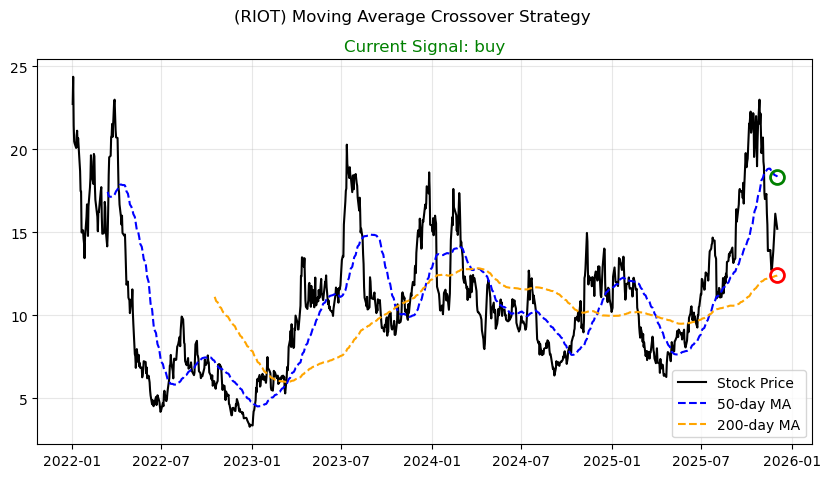

In [4]:
moving_average_crossover('RIOT', 50, 200)

## Mean Reversion Strategy (Z-Score based)
**Pros**: Use in markets without a clear trend, prices often revert to historical averages.

**Cons**: Requires careful risk management --> if stock is dropping due to real fundamental problems, betting on a reboaund can be dangerous.

In [7]:
def mean_reversion(ticker, window):
    df = yf.download(ticker, start='2022-01-01', end=dt.datetime.today())

    # calculate z-score for mean reversion
    df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
    df['Rolling_Std'] = df['Close'].rolling(window=window).std()
    df['Z_Score'] = (df['Close'][ticker] - df['Rolling_Mean']) / df['Rolling_Std']

    # buy when z-score < -2, sell when it returns
    df['Signal'] = np.where(df['Z_Score']< -2, 'buy', np.where(df['Z_Score'] > 0, 'sell', 'hold'))

    # plot the strategy
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['Z_Score'], label='Z-Score', color='black')
    ax.axhline(y=2, label=f'Upper Threshold (+2)', color='red', linestyle='dashed')
    ax.axhline(y=0, label=f'Mean', color='gray', linestyle='dashed')
    ax.axhline(y=-2, label=f'Lower Threshold (-2)', color='green', linestyle='dashed')
    ax.grid(True, which='both', axis='both', alpha=0.3)
    ax.legend()
    signal = df['Signal'][-1]
    color  = 'green' if signal == 'buy' else 'red' if signal == 'sell' else 'gray'
    ax.plot(df.index[-1], df['Z_Score'][-1], marker='o', markersize=10, markerfacecolor='none', markeredgecolor=color, markeredgewidth=2)
    fig.suptitle(f"({ticker}) Mean Reversion Strategy (Z-Score)")
    ax.set_title(f'Current Signal: {signal}', color=color)
    plt.show()

[*********************100%***********************]  1 of 1 completed


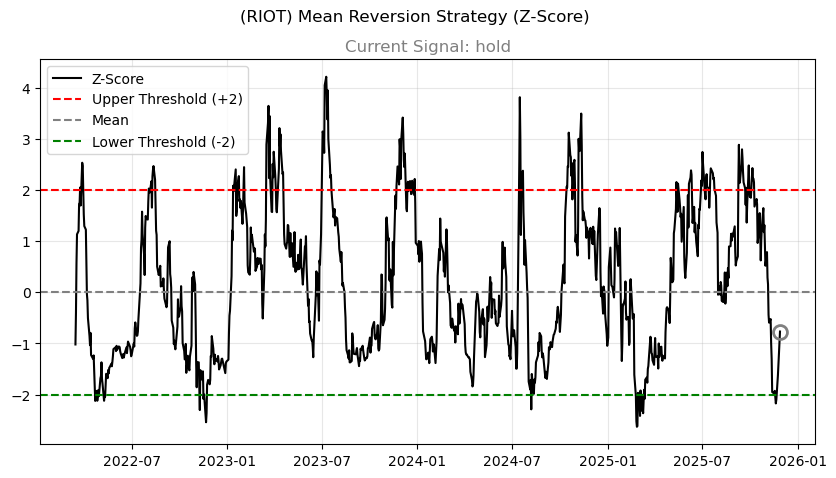

In [232]:
mean_reversion('RIOT', 50)

## Momentum Trading Strategy
**Pros**: Use when markets are rising aggressively. 

**Cons**: Can collapse in bear markets, leading to sharp losses.

In [8]:
def momentum(ticker):
    df = yf.download(ticker, start='2022-01-01', end=dt.datetime.today())

    # calculate the momentum over the past 6 months
    df['Momentum'] = df['Close'].pct_change(periods=120)

    # buy top 10% of stocks, sell bottom 10%
    df['Signal'] = np.where(df['Momentum'] > df['Momentum'].quantile(0.9), 'buy', np.where(df['Momentum'] < df['Momentum'].quantile(0.1), 'sell', 'hold'))

    # plot the strategy
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['Momentum'], label='Momentum', color='black')
    ax.axhline(y=df['Momentum'].quantile(0.9), label=f'Top 10% Threshold', color='green', linestyle='dashed')
    ax.axhline(y=df['Momentum'].quantile(0.1), label=f'Bottom 10% Threshold', color='red', linestyle='dashed')
    ax.grid(True, which='both', axis='both', alpha=0.3)
    ax.legend()
    signal = df['Signal'][-1]
    color  = 'green' if signal == 'buy' else 'red' if signal == 'sell' else 'gray'
    ax.plot(df.index[-1], df['Momentum'][-1], marker='o', markersize=10, markerfacecolor='none', markeredgecolor=color, markeredgewidth=2)
    fig.suptitle(f"({ticker}) Momentum Strategy")
    ax.set_title(f'Current Signal: {signal}', color=color)
    plt.show()

[*********************100%***********************]  1 of 1 completed


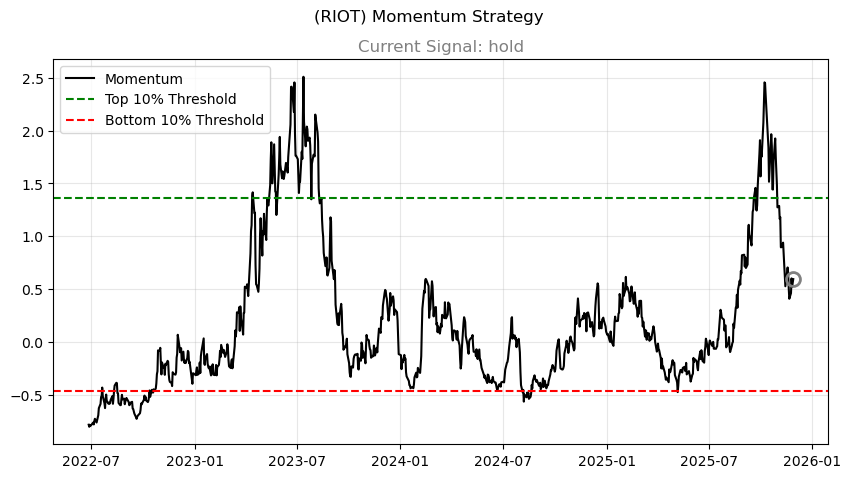

In [231]:
momentum('RIOT')

# Selecting Stocks
We will use the following criteria when selecting stocks for our portfolio:

- Financially ROBUST companies

- 95th percentile in GP, TR and FCF Growth

- (TBA) Best all-weather performance (buy or hold signals) for the 3 types of markets evaluated in the technical analysis

In [259]:
def stock_selector(amount, currency, filter=True):
    df = integrated_strategy()

    # filter for robust companies
    robust = df[df['Fundamentals'] == 'ROBUST']

    # assign weights to metrics --> favor FCF as it denotes a company with more flexibility (resilience)
    weights = {
        'TotalRevenueGrowthAvg': 0.3,
        'GrossProfitGrowthAvg': 0.3,
        'FreeCashFlowGrowthAvg': 0.4
    }

    # clean df and calculate if they are above the 90/95th percentile for the 3 metrics
    top_stocks = robust.loc[:, ['ticker','sector','industry', 'TotalRevenueGrowthAvg','GrossProfitGrowthAvg','FreeCashFlowGrowthAvg']]

    # calculate weighted metrics and percentile rank
    metrics = ['TotalRevenueGrowthAvg','GrossProfitGrowthAvg','FreeCashFlowGrowthAvg']
    for m in metrics:
        top_stocks[m] = top_stocks[m] * weights.get(m)
    top_stocks['Percentile'] = (
        top_stocks['TotalRevenueGrowthAvg'].rank(pct=True) +
        top_stocks['GrossProfitGrowthAvg'].rank(pct=True) +
        top_stocks['FreeCashFlowGrowthAvg'].rank(pct=True)
    )
    
    # get filtered list of stocks and add 
    stock_list = top_stocks[top_stocks['Percentile'] > 2.5][['ticker','sector','Percentile']].sort_values(by='Percentile', ascending=False)
    
    # get FX conversion from my input in CZK to USD stock prize, if necessary
    def get_czk_usd_rate():
        url = "https://api.frankfurter.app/latest"
        params = {
            "from": "CZK",
            "to": "USD",
        }
        resp = requests.get(url, params=params)
        resp.raise_for_status()          # will raise error if request failed
        data = resp.json()
        return data["rates"]["USD"], data["date"]
    
    if currency == 'CZK':
        rate, date = get_czk_usd_rate()
        USD_amount = rate * amount
        print(f"FX {amount} CZK→USD on {date}: {USD_amount} USD")
    else:
        USD_amount = amount

    # get last close price for stock list
    last_close = yf.download(stock_list['ticker'].tolist(), period='1d')['Close'].iloc[-1]
    stock_list['Price'] = stock_list['ticker'].map(last_close)

    # get priority from percentiles
    stock_list['Priority'] = stock_list['Percentile'] / stock_list['Percentile'].sum()

    # ideal dollar allocation
    stock_list['target_alloc_usd'] = stock_list['Priority'] * USD_amount

    # first pass: buy floor shares based on ideal allocation
    stock_list['Shares'] = (stock_list['target_alloc_usd'] // stock_list['Price']).astype(int)

    # calculate actual allocated dollars
    stock_list['allocated_usd'] = stock_list['Shares'] * stock_list['Price']

    # leftover cash
    cash_left = USD_amount - stock_list['allocated_usd'].sum()

    # greedy topping-up: buy extra shares in order of priority while you still have cash
    while True:
        affordable = stock_list[stock_list['Price'] <= cash_left]
        if affordable.empty:
            break
        
        # pick the highest-priority affordable stock
        idx = affordable.sort_values('Priority', ascending=False).index[0]
        
        # buy one more share of it
        stock_list.loc[idx, 'Shares'] += 1
        stock_list.loc[idx, 'allocated_usd'] = stock_list.loc[idx, 'Shares'] * stock_list.loc[idx, 'Price']
        
        # update leftover cash
        cash_left = USD_amount - stock_list['allocated_usd'].sum()

    stock_list['final_weight_pct'] = round(stock_list['allocated_usd'] / USD_amount * 100, 2)

    # final clean list of stocks with amount of shares, allocated USD and % in portfolio
    if filter is True:
        selected_stocks = stock_list[stock_list['Shares'] > 0][['ticker','sector','Price','Shares', 'allocated_usd', 'final_weight_pct']]
    else:
        selected_stocks = stock_list[['ticker','sector','Price','Shares', 'allocated_usd', 'final_weight_pct']].copy()
    selected_stocks[['Price','allocated_usd']] = round(selected_stocks[['Price','allocated_usd']], 2)
    
    return selected_stocks

In [260]:
stock_selector(100, 'USD', False)

[*********************100%***********************]  8 of 8 completed


,ticker,sector,Price,Shares,allocated_usd,final_weight_pct
400,WULF,financial-services,15.51,5,77.55,77.55
396,RIOT,financial-services,16.13,0,0.00,0.00
15,AIRO,industrials,8.65,1,8.65,8.65
1488,LB,energy,56.95,0,0.00,0.00
2535,OGS,utilities,83.74,0,0.00,0.00
786,LYV,communication-services,131.45,0,0.00,0.00
1323,GKOS,healthcare,106.29,0,0.00,0.00
1783,SUNS,real-estate,10.05,1,10.05,10.05


# Markets

Track the performance of three types of markets, each one corresponding to the geographic areas found to be most important in international diversification.

1. Service Economy - Europe (Switzerland) - Proxy ETF: *EWL*

2. Manufacturing Economy - Asia (Japan) - Proxy ETF: *EWJ*

3. Balanced Economy - America (USA) - Proxy ETF: *SPY*

## Market Trends and Regime Changes

1. We will track each of the markets and identify when they are 
- moving strongly in a specific direction, 
- rising aggressively, or
- without any clear trend.
  
    This is to be able to use our technical trading strategy signals more efficiently.

2. Afterwards we will also try to predict regime changes (**Bullish** or **Bearish**)

3. Finally, we will cross-analyze a market's sector weightings with our picked stock's sector to gauge which one corresponds best to it.

In [272]:
# get sector weightings for SPY, EWJ and EWL
def sector_weights_etf():
    etfs = ['SPY', 'EWJ', 'EWL']
    
    rows = []

    for symbol in etfs:
        t = yf.Ticker(symbol)
        
        # FundsData object (for ETFs / mutual funds)
        fd = t.get_funds_data()

        if fd is None:
            print(f"No funds data for {symbol}")
            continue

        # sector_weightings is a dict: {sector_key: weight_float}
        sw = fd.sector_weightings
        if not sw:
            print(f"No sector weightings for {symbol}")
            continue

        for sector, weight in sw.items():
            rows.append(
                {
                    "ticker": symbol,
                    "sector": sector,     # e.g. 'technology', 'financial_services'
                    "weight": weight,     # e.g. 0.3562 = 35.62%
                }
            )

    sector_weights_long = pd.DataFrame(rows)
    sector_weights_wide = round(sector_weights_long.pivot(index="sector", columns="ticker", values="weight").sort_index()*100, 2)

    return sector_weights_wide

In [296]:
def market_trends():
    etfs = ['SPY', 'EWJ', 'EWL']

    # get 5Y of closing prices and volumes for ETFs
    df = yf.download(etfs, period="5Y")[['Close','Volume']]

    df_flat = df.copy()
    df_flat.columns = [f"{ticker}_{field}" for field, ticker in df_flat.columns]

    # plot the ETFs

    # Keep only *_Close columns
    close_cols = [c for c in df_flat.columns if c.endswith("_Close")]
    close = df_flat[close_cols]

    min_vals = close.min()
    max_vals = close.max()
    scaled_01 = (close - min_vals) / (max_vals - min_vals)
    scaled_01.columns = [c.replace("_Close", "") for c in scaled_01.columns]

    plt.figure(figsize=(10, 5))
    scaled_01.plot(ax=plt.gca())
    plt.title("SPY vs EWJ vs EWL (Min–Max Scaled, 0–1)")
    plt.xlabel("Date")
    plt.ylabel("Scaled price (0–1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_flat

[*********************100%***********************]  3 of 3 completed


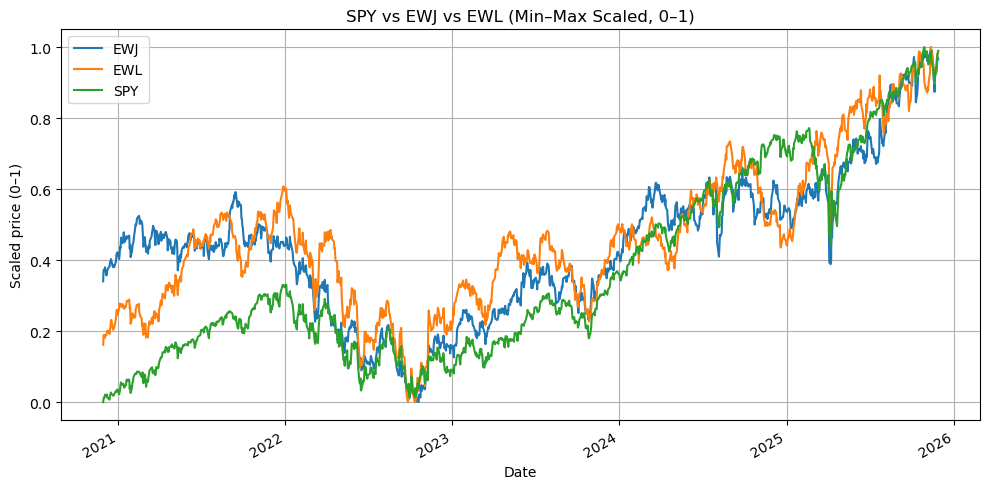

,EWJ_Close,EWL_Close,SPY_Close,EWJ_Volume,EWL_Volume,SPY_Volume
Date,,,,,,
2020-11-30,58.967861,38.489941,337.534302,13251100,1326100,83872700
2020-12-01,60.176712,39.123447,341.226105,14044600,2962300,74231400
2020-12-02,60.075966,39.087250,341.943970,6772000,976900,45927000
2020-12-03,60.222500,38.924339,341.850708,4483900,793800,62882000
2020-12-04,60.497231,39.141548,344.796631,7600500,865600,50749900
...,...,...,...,...,...,...
2025-11-21,81.190002,56.689999,659.030029,8907800,719600,123956200
2025-11-24,81.739998,56.389999,668.729980,3799400,503700,80437900
2025-11-25,81.919998,57.259998,675.020020,5197000,625800,81077100


In [297]:
market_trends()

[*********************100%***********************]  1 of 1 completed


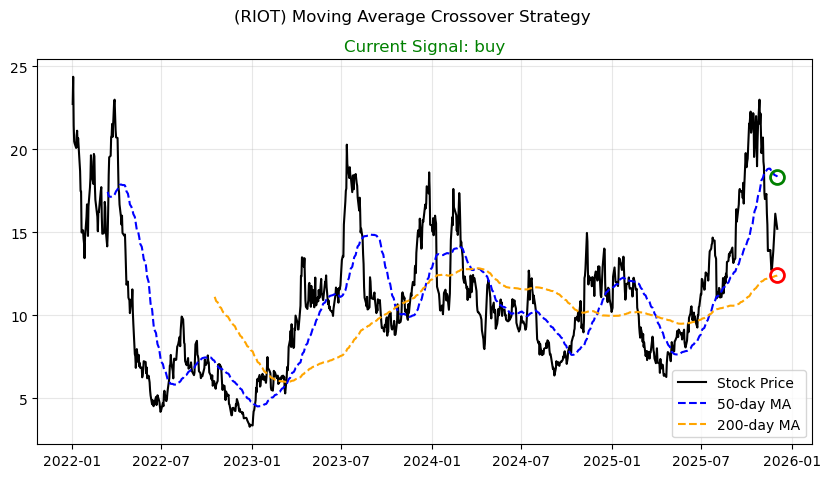

[*********************100%***********************]  1 of 1 completed


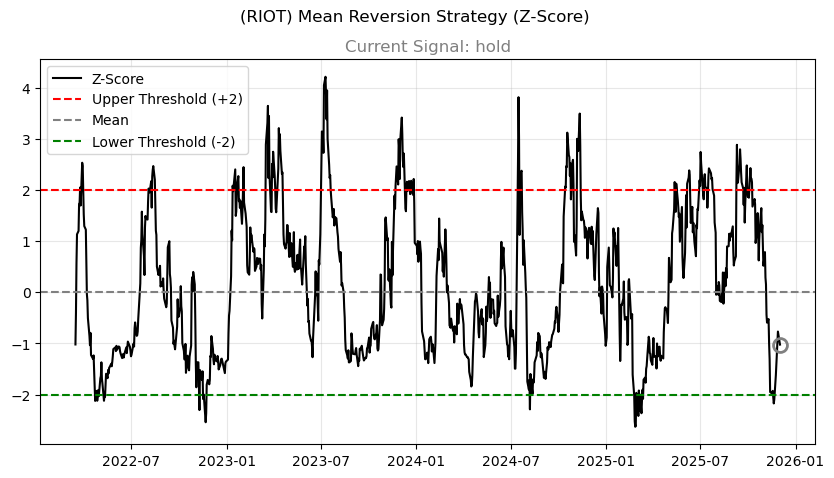

[*********************100%***********************]  1 of 1 completed


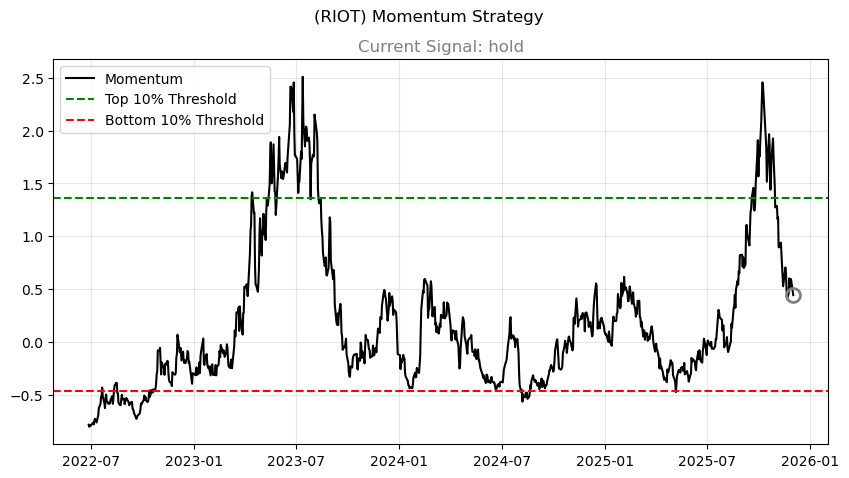

[*********************100%***********************]  1 of 1 completed


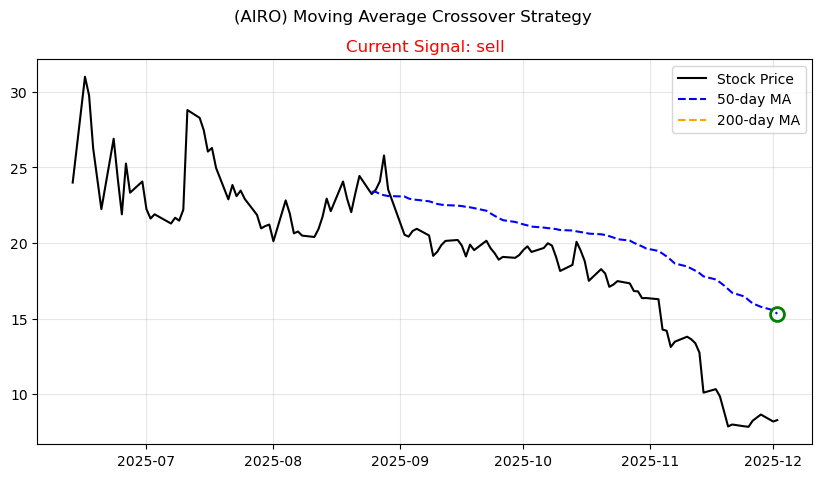

[*********************100%***********************]  1 of 1 completed


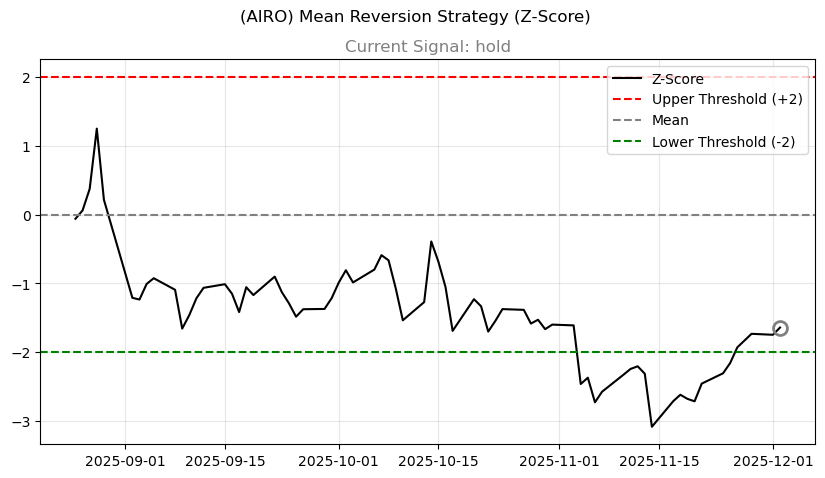

[*********************100%***********************]  1 of 1 completed


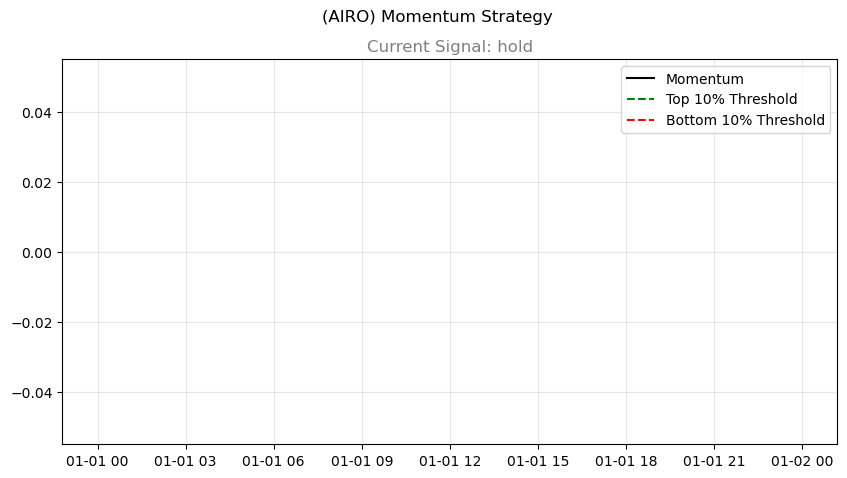

[*********************100%***********************]  1 of 1 completed


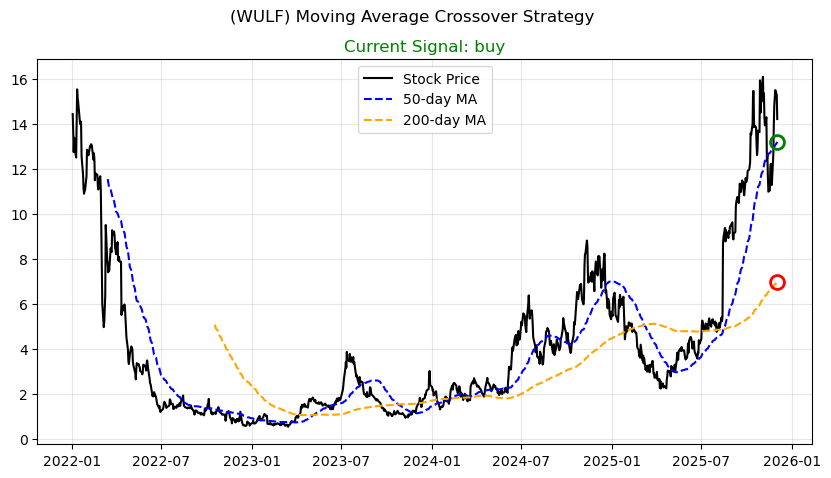

[*********************100%***********************]  1 of 1 completed


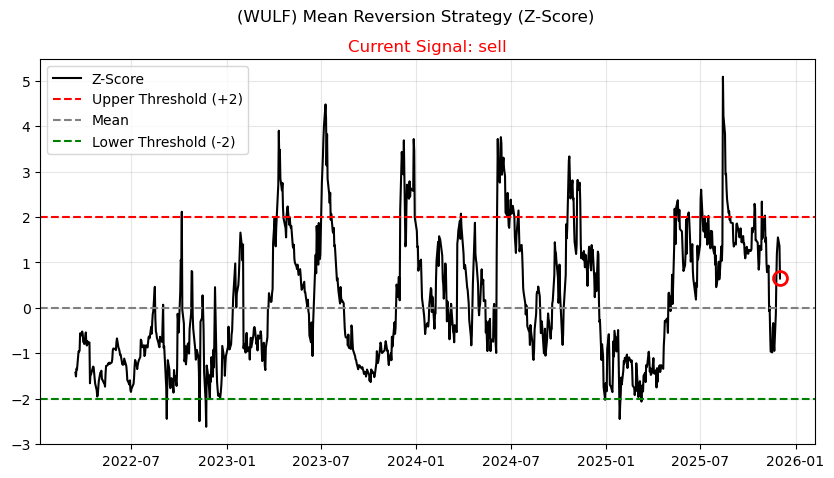

[*********************100%***********************]  1 of 1 completed


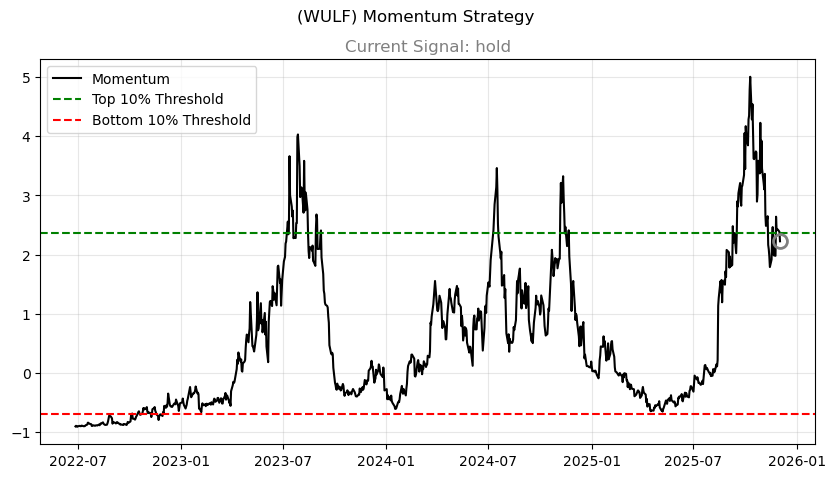

In [9]:
revolut = ['RIOT','AIRO','WULF']
for i in revolut:
    moving_average_crossover(i, 50, 200)
    mean_reversion(i, 50)
    momentum(i)